In [ ]:
import tensorflow as tf
from tensorflow import keras
import cv2
import csv
import numpy as np
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras import applications
from tensorflow.keras.models import Model, load_model
from matplotlib import pyplot as plt
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import SGD, Adam
import tensorflow_probability as tfp
tfd=tfp.distributions
tfpl=tfp.layers
from tensorflow import math
from tensorflow import random
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def read_data(path):

    #open path to read dataset.csv
    csvFile = open(path, "r")
    reader = csv.reader(csvFile)
    #assgin array to load two images and labels
    frame_0 = []
    frame_1 = []
    label = []

    for item in reader:   
    #read frames' path and labels
        frame_0_temp = item[0]
        frame_1_temp = item[1]
        label_temp = item[2]
        label_temp = float(label_temp)  
    #load frame through the frame path
        img0 = cv2.imread(frame_0_temp)
        img1 = cv2.imread(frame_1_temp)
    # use "append" to load images to array
        frame_0.append(img0)
        frame_1.append(img1)
        label.append(label_temp)
    #print('read data part: ',label)
    return frame_0, frame_1, label

def process_data(f0,f1,lab):

  #lab=keras.utils.to_categorical(lab, 1)
  f0 = np.asarray(f0)
  f1 = np.asarray(f1)
  lab = np.asarray(lab)
  #print(lab)
  return f0,f1,lab

In [ ]:
training_path = '/content/drive/MyDrive/Daming Colab/Ranking/mix_train_data_set_20000.csv'
validation_path = '/content/drive/MyDrive/Daming Colab/Ranking/mix_train_data_set_10000.csv'

frame_0_train, frame_1_train, label_train = read_data(training_path)
frame_0_val, frame_1_val, label_val = read_data(validation_path)

frame_0_train, frame_1_train, label_train = process_data(frame_0_train, frame_1_train, label_train)
frame_0_val, frame_1_val, label_val = process_data(frame_0_val, frame_1_val, label_val)

print("finish loading DATA !")

finish loading DATA !


In [ ]:
MobileNet=tf.keras.applications.MobileNet(
        input_shape=None,
        alpha=1.0,
        depth_multiplier=1,
        dropout=0.01,
        include_top=True,
        weights="imagenet",
        input_tensor=None,
        pooling=layers.AveragePooling2D,
        classes=1000,
        classifier_activation="softmax"
    )

#MobileNet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu (ReLU)               (None, 112, 112, 32) 0           conv1_bn[0][0]                   
______________________________________________________________________________________________

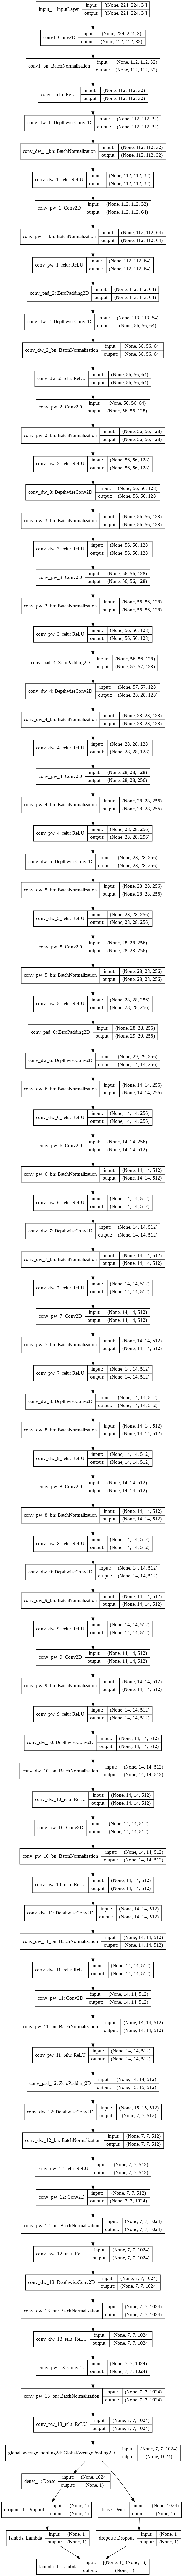

In [ ]:
x=MobileNet.get_layer('global_average_pooling2d').output

m = layers.Dense(1)(x)   
s = layers.Dense(1)(x) 

mean = layers.Dropout(0.001)(m)
log_sigma = layers.Dropout(0.001)(s)

stdlayer=layers.Lambda(lambda x:
                tf.math.exp (tf.math.subtract (x,0.0)) )
std=stdlayer(log_sigma)
    
samplelayer=layers.Lambda(lambda x:
                  x[0]+tf.math.multiply(x[1],tf.random.normal(shape=[1], mean=0.0, stddev=1)))
sample=samplelayer([mean,std])

Base=Model(inputs=MobileNet.input,outputs=[sample,mean,log_sigma])

MobileNet.trainable = False

Base.layers[-5].trainable=True
Base.layers[-4].trainable=True
Base.layers[-3].trainable=True
Base.layers[-2].trainable=True
Base.layers[-1].trainable=True

for layer in Base.layers:
    #print(layer.trainable)
    adam=keras.optimizers.Adam(0.0001)

Base.summary()
plot_model(Base, show_shapes=True, show_layer_names=True)

In [ ]:
def siamese():
  
    input_tensor = layers.Input(shape=(224, 224, 3))
    #base_model = Base()

    input_frame_0 = layers.Input(shape=(224, 224, 3))
    input_frame_1 = layers.Input(shape=(224, 224, 3))
    
    [sample0,mu0,logstd0] = Base(input_frame_0)
    [sample1,mu1,logstd1] = Base(input_frame_1)                  

    diff = keras.layers.Subtract()([sample0,sample1])  

    score = layers.Dense(1, activation='sigmoid')(diff)

    siamese_model = Model(inputs=[input_frame_0, input_frame_1], outputs=score)

    return siamese_model

siamese_model=siamese()
siamese_model.summary()
#plot_model(siamese_model, to_file='model.png', show_shapes=True, show_layer_names=True)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model (Functional)              [(None, 1), (None, 1 3230914     input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
subtract (Subtract)             (None, 1)            0           model[0][0]                

In [ ]:
siamese_model.compile(keras.optimizers.SGD(learning_rate=1e-4),
                      loss=keras.losses.binary_crossentropy,
                      metrics=['accuracy'])

history=siamese_model.fit([frame_0_train, frame_1_train], label_train, 
                          epochs=50, batch_size=20, 
                          validation_data=([frame_0_val, frame_1_val], label_val), 
                          shuffle=True,
                          verbose=1)

Epoch 1/50
1000/1000 [==============================] - 59s 42ms/step - loss: 0.6097 - accuracy: 0.7206 - val_loss: 0.5261 - val_accuracy: 0.8298
Epoch 2/50
1000/1000 [==============================] - 40s 40ms/step - loss: 0.4772 - accuracy: 0.8591 - val_loss: 0.4357 - val_accuracy: 0.8771
Epoch 3/50
1000/1000 [==============================] - 40s 40ms/step - loss: 0.4041 - accuracy: 0.8823 - val_loss: 0.3761 - val_accuracy: 0.8905
Epoch 4/50
1000/1000 [==============================] - 40s 40ms/step - loss: 0.3550 - accuracy: 0.8913 - val_loss: 0.3342 - val_accuracy: 0.9017
Epoch 5/50
1000/1000 [==============================] - 40s 40ms/step - loss: 0.3199 - accuracy: 0.8977 - val_loss: 0.3064 - val_accuracy: 0.9016
Epoch 6/50
1000/1000 [==============================] - 40s 40ms/step - loss: 0.2961 - accuracy: 0.9003 - val_loss: 0.2850 - val_accuracy: 0.9044
Epoch 7/50
1000/1000 [==============================] - 40s 40ms/step - loss: 0.2778 - accuracy: 0.9026 - val_loss: 0.2689 -

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


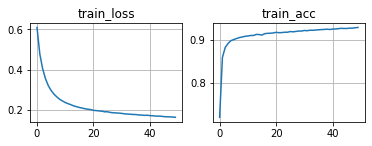

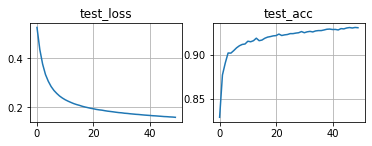

In [ ]:
print(history.history.keys())
plt.subplot(221)
plt.plot(history.history["loss"])
plt.grid()
plt.title("train_loss")

plt.subplot(222)
plt.plot(history.history["accuracy"])
plt.grid()

plt.title("train_acc")
plt.show()

plt.subplot(221)
plt.plot(history.history["val_loss"])
plt.grid()
plt.title("test_loss")

plt.subplot(222)
plt.plot(history.history["val_accuracy"])
plt.grid()
plt.title("test_acc") 
plt.show()

In [ ]:
Base.save('/content/drive/MyDrive/Daming Colab/Ranking/Model/_rankingnet_mobilenet2050_0.001dp50eMD.h5')